In [1]:
import pandas as pd
import os
import requests
import numpy as np
from collections import Counter

import seaborn as sb
from matplotlib import pyplot as plt

# Import modifiers from the most recent KOLMafia build. 
mafiaMODS = requests.get('https://svn.code.sf.net/p/kolmafia/code/src/data/modifiers.txt').text

In [2]:
import warnings
warnings.simplefilter('ignore')

In [12]:
sessionDir   = '/Users/amcguire/Library/Application Support/KoLmafia/sessions'
    
# get all hookah effects

hookah = []

# Start with my sessions & the few sent by Lyft/Aen
for file in os.listdir(sessionDir):
    
    # I use a Mac, so I have to correct for my DS store hidden files
    if file not in ['.DS_Store','bosskillinghookah.7z','Lyft_ascend20190211.txt',
                    'bosskillinghookah','Lyft_ascend20190211.html','Lyft -- 2d442advs.xlsx']:
        
        currFile = open('{}/{}'.format(sessionDir, file)).read()

        for ct, line in enumerate(currFile.split(sep='\n')):
            if line[0:22] == 'You acquire an effect:': # Always the starting string.
                if line[-3:] == '(6)': # Hookah activations always give 6 turns.
                    hookah = hookah + [line[23:-3].strip()] # Add it to the list!
                    
print('There have been {} hookah activations in your sessions.'.format(len(hookah)))

# Then add Dict's sessions!
for file in os.listdir(sessionDir+'/bosskillinghookah/'):
    
    # I use a Mac, so I have to correct for my DS store hidden files
    if file not in ['.DS_Store','bosskillinghookah.7z','Lyft_ascend20190211.txt',
                    'bosskillinghookah','Lyft_ascend20190211.html','Lyft -- 2d442advs.xlsx']:
        
        currFile = open('{}/{}'.format(sessionDir+'/bosskillinghookah/', file)).read()

        for ct, line in enumerate(currFile.split(sep='\n')):
            if line[0:22] == 'You acquire an effect:': # Always the starting string.
                if line[-3:] == '(6)': # Hookah activations always give 6 turns.
                    hookah = hookah + [line[23:-3].strip()] # Add it to the list!
                    
print('\nThere have been {} hookah activations in your sessions.'.format(len(hookah)))

There have been 1687 hookah activations in your sessions.

There have been 5911 hookah activations in your sessions.


# WAYS HOOKAH EFFECTS CAN ACTUALLY SAVE TURNS, CATEGORIZED
    1. generating inigos in a free fight so you have all 5 turns of it (1 turn)
    2. the stone wool effect (depending on temple status can save a semirare or hunting for wool)
    3. meat drop effects when you're doing nuns (anywhere from <1 to 2 turns @ maximum)
    4. item drop effects when you're short on capping something (<1 turn)
    5. init for modern zmobs (1-2 turns potentially)
    6. sleaze dmg for protestor mob (very rare, but possibly saves a wish?)
    7. prismatic dmg for tavern (or just whatever your missing, saves a turn maybe); NOT COVERED
    8. sleaze res for blech house (rare and almost certainly 100% unnecessary)
    9. covetous robbery making you extremely rich early in-run
    10. +statgain flat or % effects
    11. very, very high stat increases

In [16]:
def modParse(x):
    ''' Quick custom function w/ exception for parsing modifiers from plaintext '''
    try: 
        return int(x.split('+')[1])
    except:
        return 0

def parseEffects(eff):
    ''' Function to parse through effects and generate #s according to useful in-run
        applications of hookah/horsery effects, per those examined above. I am ignoring
        Prismatic damage out of laziness; if you want to add it, just do a long 
        any-type list comp like I did for the flat/pct stats. '''
    
    meatDrop  = 0
    itemDrop  = 0
    init      = 0
    sleazeDmg = 0
    sleaseRes = 0
    poolSkill = 0
    
    famWeight = 0
    
    flatXP    = 0
    pctXP     = 0
    
    flatstat  = 0
    pctstat   = 0
    
    for x in eff:
        
        if     'Initiative'            in x: init = init + modParse(x)
        elif   'Meat Drop'             in x: meatDrop = meatDrop + modParse(x)
        elif   'Item Drop'             in x: itemDrop = itemDrop + modParse(x)
        elif   'Sleaze Damage'         in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Spell Damage'   in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Resistance'     in x: sleaseRes = sleaseRes + modParse(x)
        elif   'Pool Skill'            in x: poolSkill = poolSkill + modParse(x)
            
        elif   'Familiar Weight'       in x: famWeight = famWeight + modParse(x)
        
        elif   'Experience Percent'    in x: pctXP = pctXP + modParse(x)
        elif   'Experience (Familiar)' in x: flatXP = flatXP + 0
        elif   'Experience'            in x: flatXP = flatXP + modParse(x)
        
        elif any(y in x for y in ['Moxie Percent','Mysticality Percent','Muscle Percent']): 
            pctstat = pctstat + modParse(x) 
        elif any(y in x for y in ['Moxie','Mysticality','Muscle']): 
            flatstat = flatstat + modParse(x)
    
    effDict = {'meat':meatDrop, 'item':itemDrop,'init':init, 'sleazeDmg':sleazeDmg, 
               'sleazeRes':sleaseRes, 'poolSkill':poolSkill, 'famWeight':famWeight,
               'flatXP':flatXP,'pctXP':pctXP,'flatStats':flatstat,'pctStat':pctstat}
    
    return effDict

def parseRawMods(txt):
    ''' Parsing out what the effects actually do. Generates a dictionary. '''
    if txt == '': # Remove blank rows.
        return ''
    elif txt[0] == '#': # Remove comments.
        return ''
    elif txt == '3': # Remove the weird extraneous "3" that starts the file
        return ''
    elif '\tAvatar: ' in txt: # Remove avatar potions.
        return
    
    effType = txt.split('\t')[0]
    effName = txt.split('\t')[1]
    effects = txt.split('\t')[2].split(',')
    effDict = parseEffects(effects)
    
    return {'NAME':effName,'TYPE':effType,'EFFECTSLIST':effects, **effDict}
    
modsList = list(filter(None, [parseRawMods(x) for x in mafiaMODS.split('\n')]))
modsDF = pd.DataFrame(modsList)

In [15]:
modsDF.loc[modsDF['NAME']=='Stone-Faced',]

,EFFECTSLIST,NAME,TYPE,famWeight,flatStats,flatXP,init,item,meat,pctStat,pctXP,poolSkill,sleazeDmg,sleazeRes
5150,[Damage Reduction: 3],Stone-Faced,Effect,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# testing to make sure the effects are properly generating

for x in hookah[5:10]:
    print('{} gives the effects: {}'.format(x, modsDF.loc[modsDF['NAME']==x,'EFFECTSLIST'].values))

The Halls of Moxiousness gives the effects: [list(['Experience (Moxie): +3'])]
Always be Collecting gives the effects: [list(['Item Drop: +50', ' Meat Drop: +100'])]
The Wisdom... of the Future gives the effects: [list(['Mysticality Percent: +50', ' Mysticality: +15', ' Experience (Mysticality): +3'])]
Spiky Hair gives the effects: [list(['Muscle: +6', ' Moxie: +6'])]
Cruisin' for a Bruisin' gives the effects: [list(['Weapon Damage Percent: +100'])]


In [19]:
# Use an efficient counter function to figure out how many activations each respective skill had
countHookah = Counter(hookah)
modsDF['hookah'] = [countHookah[x] for x in modsDF.NAME]

# When sorting by activations, noticed that Sugar Rush & the general 
#   store effects were high up. This makes some sense, as those can 
#   be generated in multiples of 3. Will floor these to 5 on the 
#   assumption mafia is incorrectly categorizing them.

print(modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(5))

for effect in ['Sugar Rush', "Go Get 'Em, Tiger!", "Glittering Eyelashes", "Butt-Rock Hair"]:
    modsDF.loc[modsDF['NAME'] == effect,['hookah']] = 5

modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(10)

                      NAME  hookah
4254    Go Get 'Em, Tiger!      17
5170            Sugar Rush      16
4248  Glittering Eyelashes      15
5017         Sleazy Weapon      13
3641   Angry like the Wolf      12


,NAME,hookah
5017,Sleazy Weapon,13
3641,Angry like the Wolf,12
3670,Astral Shell,11
5496,20/20 Vision,11
4694,Neuroplastici Tea,11
4394,Human-Elf Hybrid,11
4285,Grrrrrrreat!,11
3804,Bricked-In,11
3584,20/20 Vision,11
4231,Fustulent,11


In [20]:
# Looking at effects that do not appear to be hookah-activated, we see a 
#   lot of ML & "negative" effects; this fits our intuition. That said, 
#   there are a few here that are probably actually eligible.

modsDF.loc[(modsDF['hookah']==0) & (modsDF['TYPE'] == 'Effect'),['EFFECTSLIST','NAME']].head()

,EFFECTSLIST,NAME
3579,[Moxie: -5],&quot;The Disease&quot;
3581,"[Muscle: +6, Moxie: -3]",1337p4n7Z
3582,"[Experience: +3, Experience (familiar): +3]","2 Hearts, 1 Mind"
3588,"[Familiar Weight: +5, Experience (familiar): ...",A Girl Named Sue
3589,[Monster Level: +2],[597]A Little Bit Evil


In [21]:
# Effects that are useful in and of themselves:

usefulEffects = ['Stone-Faced', 'Craft Tea', "Inigo's Incantation of Inspiration", "Covetous Robbery","Dirty Pear"]

for eff in usefulEffects:
    print('{} occurred in {} of {} activations, a rate of {:.2%}.'.format(eff,countHookah[eff],len(hookah),countHookah[eff]/len(hookah)))

Stone-Faced occurred in 5 of 5911 activations, a rate of 0.08%.
Craft Tea occurred in 3 of 5911 activations, a rate of 0.05%.
Inigo's Incantation of Inspiration occurred in 4 of 5911 activations, a rate of 0.07%.
Covetous Robbery occurred in 6 of 5911 activations, a rate of 0.10%.
Dirty Pear occurred in 2 of 5911 activations, a rate of 0.03%.


In [22]:
def summarizeField(df, fName, c='g', lowBound=0):
    ''' Summarization function for individual fields. '''
    
    # Filter down to only effects w/ hookah activations & relevant column for summarization
    df = df.loc[df['hookah']>0,[fName,'hookah']]
    
    allActivations = sum(df['hookah'])
    
    # Cut out non-relevant activations now that we know the #
    df = df.loc[df[fName]>lowBound,:]
    
    print('For {}, there were {} relevant activations out of {}, a rate of {:.2%}.\n'.format(fName,sum(df['hookah']),allActivations,sum(df['hookah'])/allActivations))
    
    allAvg = sum(df[fName]*df['hookah'])/allActivations
    popAvg = sum(df[fName]*df['hookah'])/sum(df['hookah'])
    print('  Average per activation:    +{:0.5}'.format(allAvg))
    print('  Average when activated:    +{:0.5}\n'.format(popAvg))
    print('  Maximum buff:              +{}, {} times\n'.format(max(df[fName].values),sum(df.loc[df[fName]==max(df[fName]),['hookah']].values[0])))
    
    # Generate a nice histogram of the distribution of activation buffs assuming equal activations
    fig, ax = plt.subplots()
    sb.distplot(df[fName],kde = False, color=c,ax=ax)
    ax.set(ylabel="# of Activations") 
    sb.set_style("dark")
    sb.despine()
    plt.show()
    

For init, there were 363 relevant activations out of 5545, a rate of 6.55%.

  Average per activation:    +3.3365
  Average when activated:    +50.967

  Maximum buff:              +300, 7 times



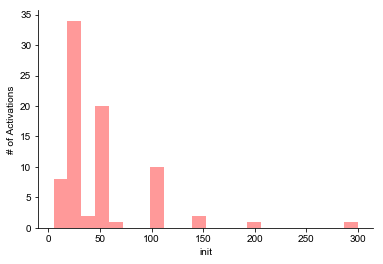

For meat, there were 263 relevant activations out of 5545, a rate of 4.74%.

  Average per activation:    +2.1959
  Average when activated:    +46.297

  Maximum buff:              +200, 7 times



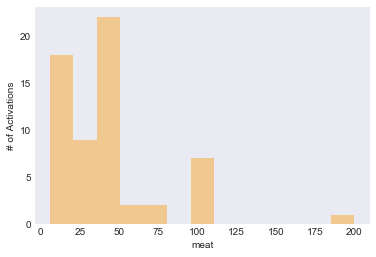

For item, there were 392 relevant activations out of 5545, a rate of 7.07%.

  Average per activation:    +1.7151
  Average when activated:    +24.26

  Maximum buff:              +100, 6 times



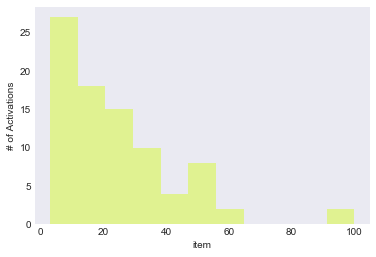

For sleazeDmg, there were 211 relevant activations out of 5545, a rate of 3.81%.

  Average per activation:    +0.86456
  Average when activated:    +22.72

  Maximum buff:              +100, 2 times



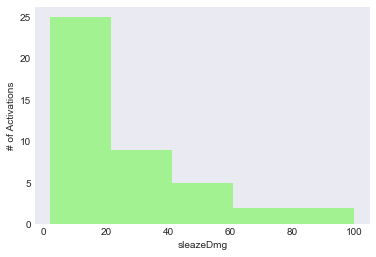

For sleazeRes, there were 184 relevant activations out of 5545, a rate of 3.32%.

  Average per activation:    +0.080613
  Average when activated:    +2.4293

  Maximum buff:              +9, 3 times



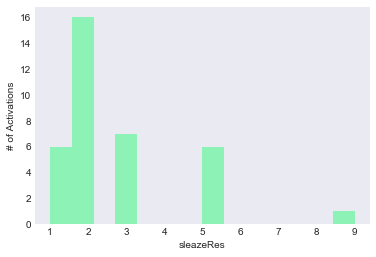

For poolSkill, there were 20 relevant activations out of 5545, a rate of 0.36%.

  Average per activation:    +0.014788
  Average when activated:    +4.1

  Maximum buff:              +5, 5 times



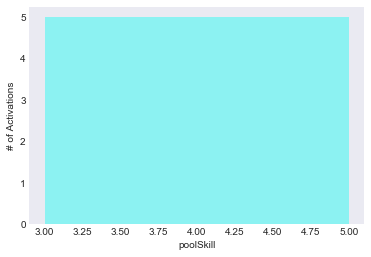

For famWeight, there were 170 relevant activations out of 5545, a rate of 3.07%.

  Average per activation:    +0.18016
  Average when activated:    +5.8765

  Maximum buff:              +10, 5 times



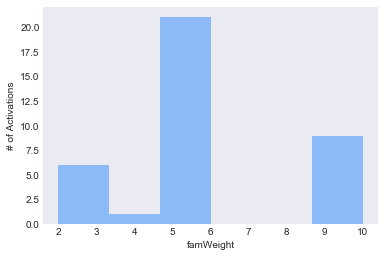

For flatXP, there were 337 relevant activations out of 5545, a rate of 6.08%.

  Average per activation:    +0.23138
  Average when activated:    +3.8071

  Maximum buff:              +12, 4 times



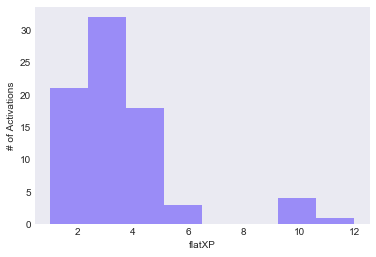

For pctXP, there were 53 relevant activations out of 5545, a rate of 0.96%.

  Average per activation:    +0.13616
  Average when activated:    +14.245

  Maximum buff:              +25, 2 times



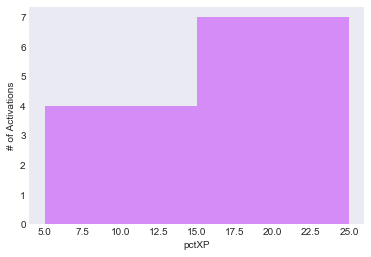

For flatStats, there were 680 relevant activations out of 5545, a rate of 12.26%.

  Average per activation:    +2.8757
  Average when activated:    +23.45

  Maximum buff:              +120, 4 times



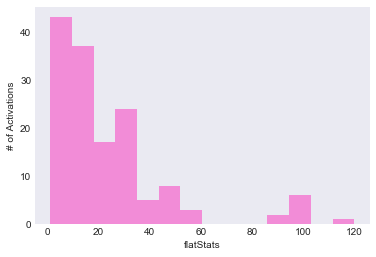

For pctStat, there were 1022 relevant activations out of 5545, a rate of 18.43%.

  Average per activation:    +14.701
  Average when activated:    +79.76

  Maximum buff:              +600, 3 times



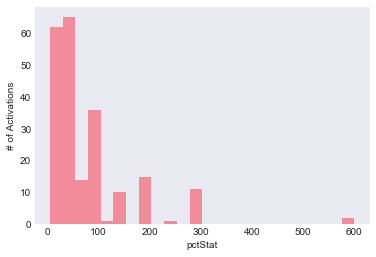

In [23]:
buffsAnalyzed = ['init','meat','item','sleazeDmg','sleazeRes','poolSkill',
                 'famWeight','flatXP','pctXP','flatStats','pctStat']

cmap = plt.cm.get_cmap('hsv',len(buffsAnalyzed))

for i, x in enumerate(buffsAnalyzed):
    summarizeField(modsDF, x, c=cmap(i))

In [24]:
modsDF.to_csv('hookahData.csv')